In [152]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb

from scipy import stats
from sklearn import linear_model
from sklearn import tree
# from sklearn.metrics import r2_score

In [133]:
# Extending sklearn class to add p and t values to the model.
class LinearRegression(linear_model.LinearRegression):
    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self).__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1, get_p_value=True):
        self = super(LinearRegression, self).fit(X, y, n_jobs)

        self.t, self.p = 0, 0
        if(get_p_value):
            sse = np.sum((self.predict(X) - y) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
            se = np.array([np.sqrt(np.diagonal(sse * np.linalg.inv(np.dot(X.T, X))))])
            self.t = self.coef_ / se
            self.t = np.round(self.t, 3)
            self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))
            self.p = np.round(self.p[0], 3)
        return self

In [134]:
# This method will return the pearson correlation of two lists.
def get_correlation(x, y):
    return np.round(stats.pearsonr(x, y)[0], 3)

In [135]:
def feature_matrix(ds="ml-1M", metric="NDCG100"):
    DS = f"../features_table/{ds}/{metric}.csv"
    return pd.read_csv(DS, sep='\s*,\s*', index_col=0, engine='python')

In [136]:
def plot_heat_map(x_names, y_names, z_values, title):
    df = pd.DataFrame(data=z_values, index=x_names, columns=y_names)
    fig, ax = plt.subplots(figsize=(11, 9))
    sb.heatmap(df)
    plt.show()

In [137]:
def get_x_y_from_pandas(df, features_str, algo):
    X, Y = [], []
    xs = [[] for _ in range(len(features_str))]
    
    for i, f in enumerate(features_str):
        xs[i] = df[[f]].to_numpy().flatten()
    ys = df[[algo]].to_numpy().flatten()
    
    for i in range(len(xs[0])):
        X.append([x[i] for x in xs])
        Y.append(ys[i])
    return np.array(X), np.array(Y)
    

## Variables
Variables that will be usefull on the code.

In [148]:
features_str = [
    "space_size",
    "shape",
    "density",
    "rpu",
    "rpi",
    "gini_u",
    "gini_i",
    "pop_avg",
    "pop_std",
    "pop_skew",
    "pop_kurtosis",
    "long_tail_avg",
    "long_tail_std",
    "long_tail_skew",
    "long_tail_kurtosis"
]

algos = [
    "UserKNN-Amplified",
    "UserKNN-BM25",
    "UserKNN-Cosine",
    "UserKNN-IDF",
    "ItemKNN-AdjustedCosine",
    "BPR",
    "MF",
    "SVD",
    "PMF",
    "NMF"
]

df = feature_matrix()

### Independent variables Correlation
This will check how each independent variable is correlated, and aims to drop any redundance that could decrease the regression efficacy.

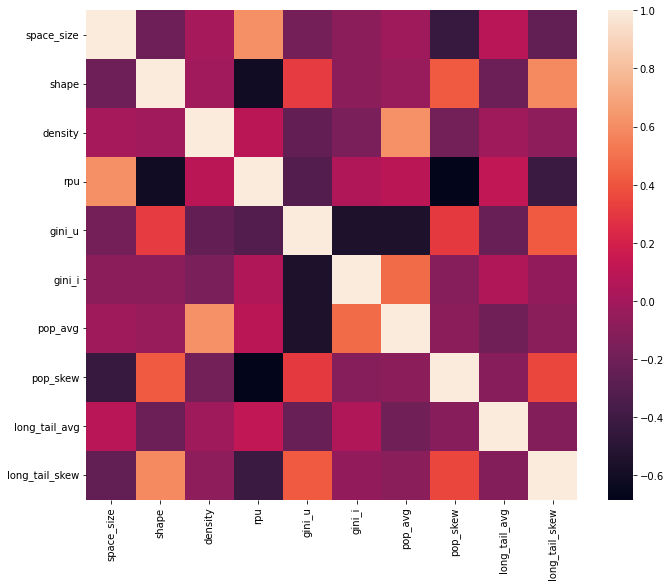

In [139]:
correlations = np.zeros((len(features_str), len(features_str)))
for i, f1 in enumerate(features_str):
    for j, f2 in enumerate(features_str):
        x1, x2 = df[[f1]].to_numpy().flatten(), df[[f2]].to_numpy().flatten()
        correlations.itemset((i, j), get_correlation(x1, x2))
plot_heat_map(features_str, features_str, correlations, "Correlations map")

## Regression Evaluation
Here we start to eval the regression metrics for this model. As done in the article, some of the metrics will be dropped to avoid influence of the correlation showed above.

In [140]:
z = np.zeros((len(features_str)+1, len(algos)))
for i, algo in enumerate(algos):
    x, y = get_x_y_from_pandas(df, features_str, algo)
    model = LinearRegression()
    model.fit(x,y)
    r_sq = np.round(model.score(x, y), 3)
    p_values = model.p
    z.itemset((0, i), r_sq)
    for j in range(len(features_str)):
        z.itemset((j+1, i), p_values.item(j))
ans = pd.DataFrame(data=z, index=["R2"] + features_str, columns=algos)
print(ans)

                UserKNN-Amplified  UserKNN-BM25  UserKNN-Cosine  UserKNN-IDF  \
R2                           0.88         0.924           0.875        0.915   
space_size                   0.00         0.000           0.001        0.000   
shape                        0.00         0.000           0.000        0.000   
density                      0.00         0.000           0.000        0.000   
rpu                          0.00         0.000           0.000        0.000   
gini_u                       0.00         0.003           0.000        0.000   
gini_i                       0.00         0.000           0.000        0.000   
pop_avg                      0.00         0.086           0.000        0.011   
pop_skew                     0.00         0.000           0.000        0.000   
long_tail_avg                0.00         0.000           0.000        0.000   
long_tail_skew               0.00         0.000           0.000        0.000   

                ItemKNN-AdjustedCosine 

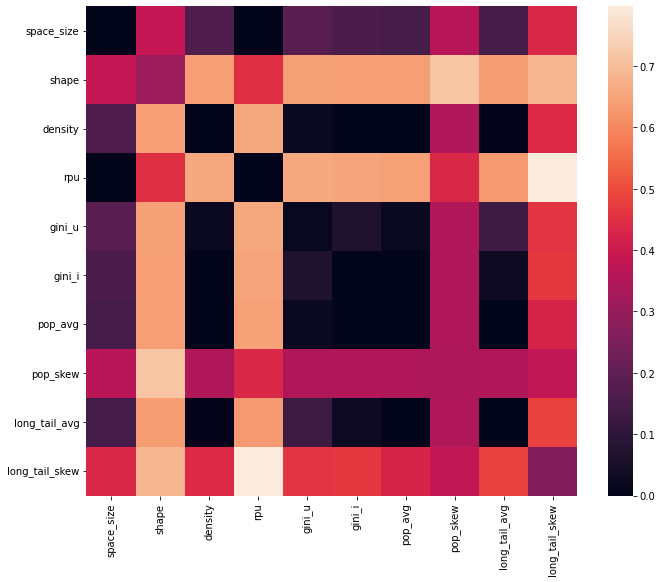

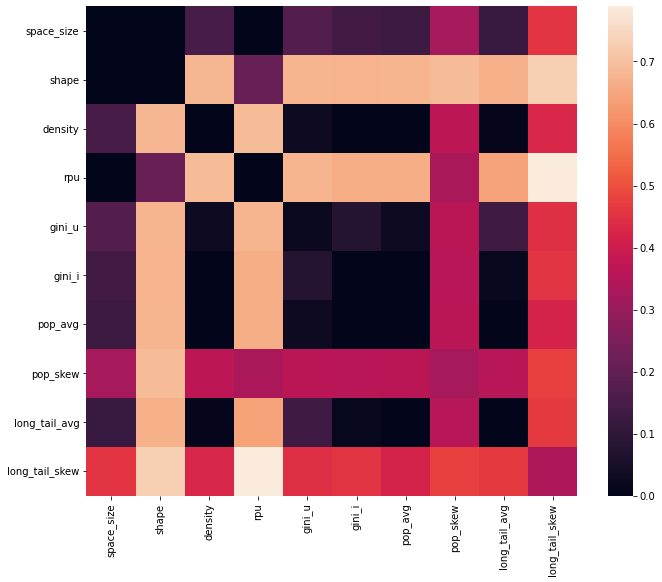

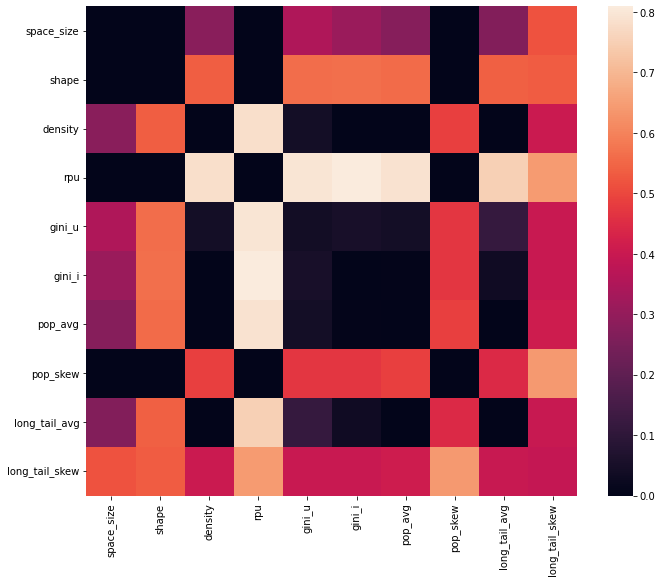

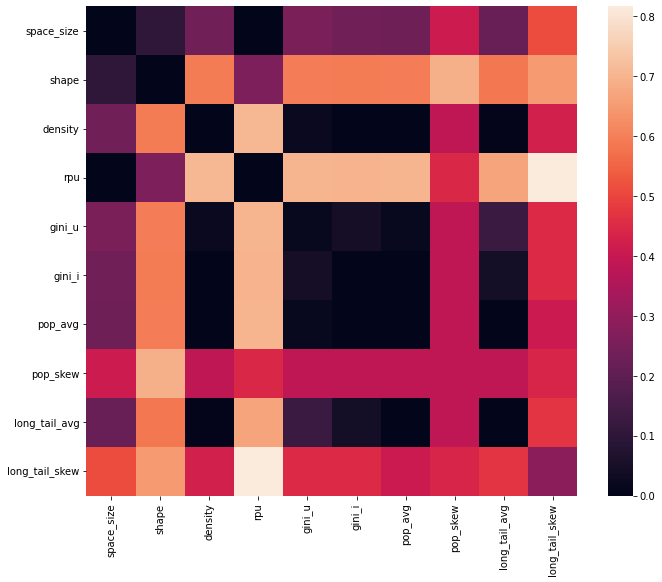

In [144]:
algos_2 = ["UserKNN-Amplified", "ItemKNN-AdjustedCosine", "BPR", "NMF"]
z2 = np.zeros((len(features_str), len(features_str)))

for i, algo in enumerate(algos_2):
    for j, f1 in enumerate(features_str):
        for k, f2 in enumerate(features_str):
            features = [f1, f2]
            x, y = get_x_y_from_pandas(df, features, algo)
            model = LinearRegression()
            model.fit(x,y,get_p_value=False)
            r_sq = np.round(model.score(x, y), 3)
            if(r_sq < 0):
                r_sq = 0.0
            z2.itemset((j, k), r_sq)
    plot_heat_map(features_str, features_str, z2, f"R2 for 2 DCs - {algo}")
    

# Decision Tree!!!!

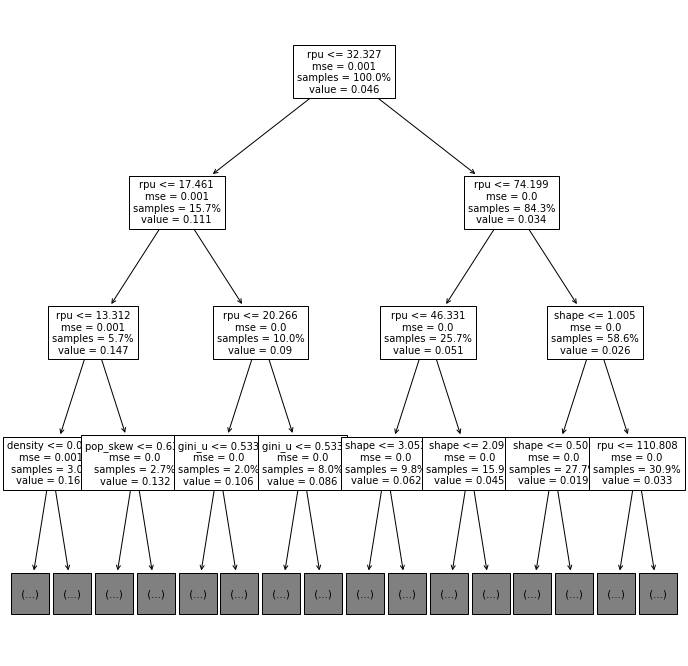

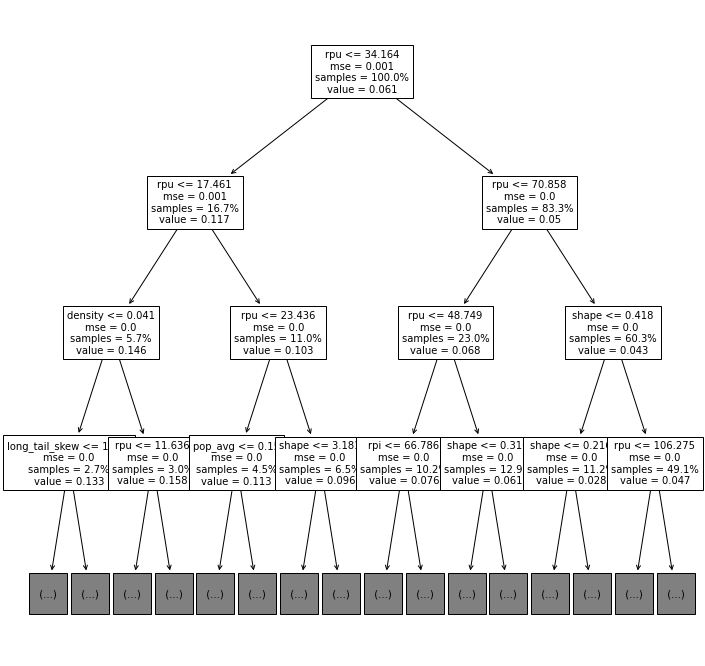

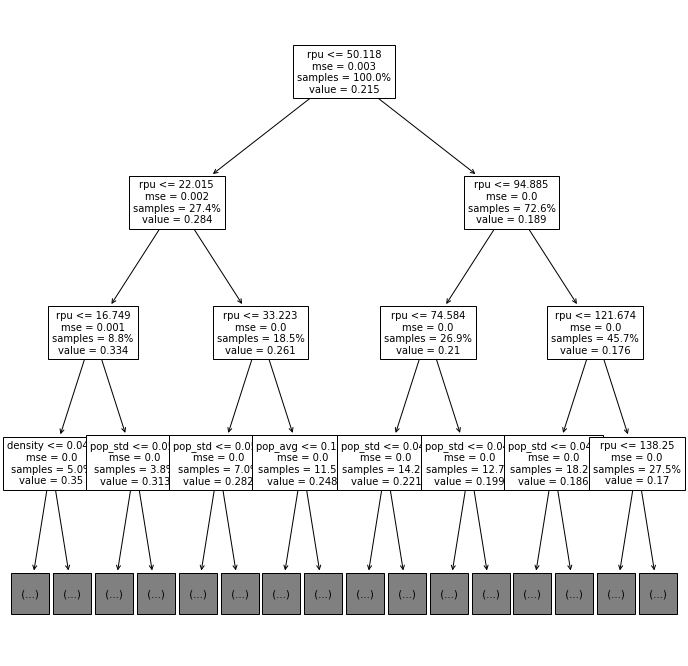

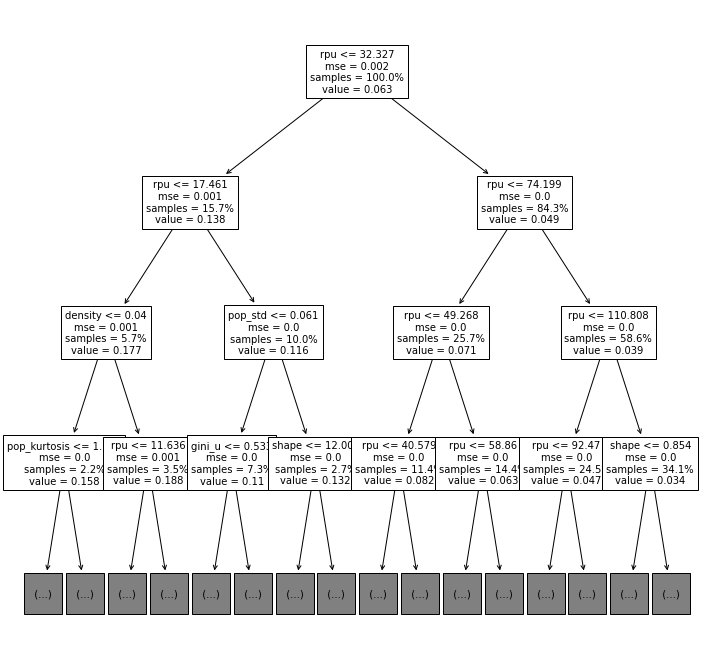

In [160]:
features_str = [
    "space_size",
    "shape",
    "density",
    "rpu",
    "rpi",
    "gini_u",
    "gini_i",
    "pop_avg",
    "pop_std",
    "pop_skew",
    "pop_kurtosis",
    "long_tail_avg",
    "long_tail_std",
    "long_tail_skew",
    "long_tail_kurtosis"
]

# algos = [
#     "UserKNN-Amplified",
#     "UserKNN-BM25",
#     "UserKNN-Cosine",
#     "UserKNN-IDF",
#     "ItemKNN-AdjustedCosine",
#     "BPR",
#     "MF",
#     "SVD",
#     "PMF",
#     "NMF"
# ]
algos = ["UserKNN-Amplified", "ItemKNN-AdjustedCosine", "BPR", "NMF"]

df = feature_matrix()

for i, algo in enumerate(algos):
    x, y = get_x_y_from_pandas(df, features_str, algo)
    model_tree = tree.DecisionTreeRegressor()
    model_tree.fit(x,y)
    plt.figure(figsize=(12,12))
    tree.plot_tree(model_tree, max_depth=3, feature_names=features_str, proportion=True, fontsize=10) 